This is to test TTS models with benchmark sentences for speech synthesis.

Before running this script please DON'T FORGET: 
- to set file paths.
- to download related model files from TTS and WaveRNN.
- to checkout right commit versions (given next to the model) of TTS and WaveRNN.
- to set the right paths in the cell below.

Repositories:
- TTS: https://github.com/mozilla/TTS
- WaveRNN: https://github.com/erogol/WaveRNN

In [ ]:
TTS_PATH = "../../"
WAVERNN_PATH ="../../../"
SV_PATH = "../../../"

In [14]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import json
import numpy as np
from pathlib import Path
from collections import OrderedDict
from matplotlib import pylab as plt

%pylab inline
rcParams["figure.figsize"] = (16,5)

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
sys.path.append(WAVERNN_PATH) # set this if TTS is not installed globally

import librosa
import librosa.display

from synthesizer.models.tacotron2 import Tacotron2
from synthesizer.layers import *
from synthesizer.utils.data import *
from synthesizer.utils.audio import AudioProcessor
from synthesizer.utils.generic_utils import load_config, setup_model
from synthesizer.utils.text import text_to_sequence
from synthesizer.utils.synthesis import synthesis, synthesis2
from synthesizer.utils.visual import visualize

import IPython
from IPython.display import Audio

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/search/hadoop02/suanfa/anaconda3/envs/tacotron2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [190]:
# Set constants
# new Biaobei-December-11-2019_08+24AM-536ef91
# old Biaobei-November-29-2019_07+21AM-649312f
ROOT_PATH = '../../synthesizer/output/SV2TTS-synthesis-January-15-2020_01+56PM-3a34127/'
MODEL_PATH = ROOT_PATH + '/checkpoint_244000.pth.tar'
CONFIG_PATH = '../../synthesizer/config.json'
OUT_FOLDER = '../output/benchmark_samples/'
CONFIG = load_config(CONFIG_PATH)
VOCODER_MODEL_PATH = "../../../WaveRNN//output/WaveRNN-December-12-2019_05+43PM-e8886be/model_checkpoints/best_model.pth.tar"
VOCODER_CONFIG_PATH = "../../../WaveRNN/config.json"
VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
ENCODER_PATH = Path("../../encoder/saved_models/pretrained.pt")
use_cuda = True

# Set some config fields manually for testing
CONFIG.windowing = False
CONFIG.prenet_dropout = True
CONFIG.separate_stopnet = True
CONFIG.use_forward_attn = True
CONFIG.forward_attn_mask = True
CONFIG.stopnet = True

# Set the vocoder
use_gl = False # use GL if True
batched_wavernn = True    # use batched wavernn inference if True

In [191]:
# LOAD TTS MODEL
from synthesizer.utils.text.symbols import symbols, phonemes

# multi speaker 
if CONFIG.use_speaker_embedding:
    speakers = json.load(open(f"{ROOT_PATH}/speakers.json", 'r'))
    speakers_idx_to_id = {v: k for k, v in speakers.items()}
else:
    speakers = []
    speaker_id = None

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, len(speakers), CONFIG)

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()
print(cp['step'])
print(cp['r'])

# set model stepsize
if 'r' in cp:
    model.decoder.set_r(cp['r'])

 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:401
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > sound_norm:False
 | > n_fft:800
 | > hop_length:200
 | > win_length:800
244000
1


In [102]:
# LOAD WAVERNN
if use_gl == False:
    from WaveRNN.models.wavernn import Model
    from WaveRNN.utils.audio import AudioProcessor as AudioProcessorVocoder
    bits = 10
    ap_vocoder = AudioProcessorVocoder(**VOCODER_CONFIG.audio)    
    wavernn = Model(
            rnn_dims=512,
            fc_dims=512,
            mode=VOCODER_CONFIG.mode,
            mulaw=VOCODER_CONFIG.mulaw,
            pad=VOCODER_CONFIG.pad,
            upsample_factors=VOCODER_CONFIG.upsample_factors,
            feat_dims=VOCODER_CONFIG.audio["num_mels"],
            compute_dims=128,
            res_out_dims=128,
            res_blocks=10,
            hop_length=ap_vocoder.hop_length,
            sample_rate=ap_vocoder.sample_rate,
            use_upsample_net = True,
            use_aux_net = True
        ).cuda()

    check = torch.load(VOCODER_MODEL_PATH)
    wavernn.load_state_dict(check['model'], strict=False)
    if use_cuda:
        wavernn.cuda()
    wavernn.eval();
    print(check['step'])

 > Setting up Audio Processor...
 | > fft size: 4096, hop length: 600, win length: 2400
 | > Audio Processor attributes.
   | > bits:None
   | > sample_rate:48000
   | > num_mels:80
   | > min_level_db:-100
   | > frame_shift_ms:12.5
   | > frame_length_ms:50
   | > ref_level_db:20
   | > num_freq:2049
   | > power:1.5
   | > preemphasis:0.98
   | > griffin_lim_iters:60
   | > signal_norm:True
   | > symmetric_norm:True
   | > mel_fmin:125.0
   | > mel_fmax:7600.0
   | > max_norm:4.0
   | > clip_norm:True
   | > do_trim_silence:True
   | > n_fft:4096
   | > hop_length:600
   | > win_length:2400
447150


In [103]:
from encoder import inference as encoder
from encoder.params_data import *

In [104]:
encoder.load_model(ENCODER_PATH)

Loaded encoder "pretrained.pt" trained to step 204501


In [122]:
def tts(text, target_wav, tts_model, CONFIG, use_cuda, ap_tts, ap_vocoder, use_gl, figures=False, target=3000, overlap=500, create_gl=False):
    t_1 = time.time()
    preprocessed_wav = encoder.preprocess_wav(target_wav, sampling_rate)
    embed = torch.FloatTensor(encoder.embed_utterance(preprocessed_wav))
    embed = embed.unsqueeze(0).cuda()
    print(embed.shape)
    wave_gl, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis2(tts_model, text, CONFIG, use_cuda, ap_tts, embed, False, CONFIG.enable_eos_bos_chars, do_trim_silence=False, create_gl=create_gl)
    if CONFIG.model == "Tacotron" and not use_gl:
        # coorect the normalization differences b/w TTS and the Vocoder.
        mel_postnet_spec = ap.out_linear_to_mel(mel_postnet_spec.T).T
    mel_postnet_spec = ap._denormalize(mel_postnet_spec)
    mel_postnet_spec = ap_vocoder._normalize(mel_postnet_spec)
    print(" > Tacotron2-time: {}".format(time.time() - t_1))
    if not use_gl:
        waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=target, overlap=overlap, ap=ap_vocoder)
        # waveform = wavernn.generate(mel_postnet_spec.T.unsqueeze(0).cuda(), batched=batched_wavernn, target=3000, overlap=100, ap=ap_vocoder)
    print("\n >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)
    if create_gl:
        IPython.display.display(Audio(wave_gl, rate=CONFIG.audio['sample_rate']))
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

### Comparision with https://mycroft.ai/blog/available-voices/

In [194]:
target_wav = "./lzl.mp3"

In [187]:
len(preprocessed_wav)

80000

In [188]:
6*44100

264600

In [196]:
sentence =  "da4 jia1 hao3"

/search/hadoop02/suanfa/anaconda3/envs/tacotron2/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


 > Tacotron2-time: 1.739086627960205
62700/63000 -- batch_size: 3 -- gen_rate: 3.5 kHz -- x_realtime: 0.1  
 >  Run-time: 19.875079870224


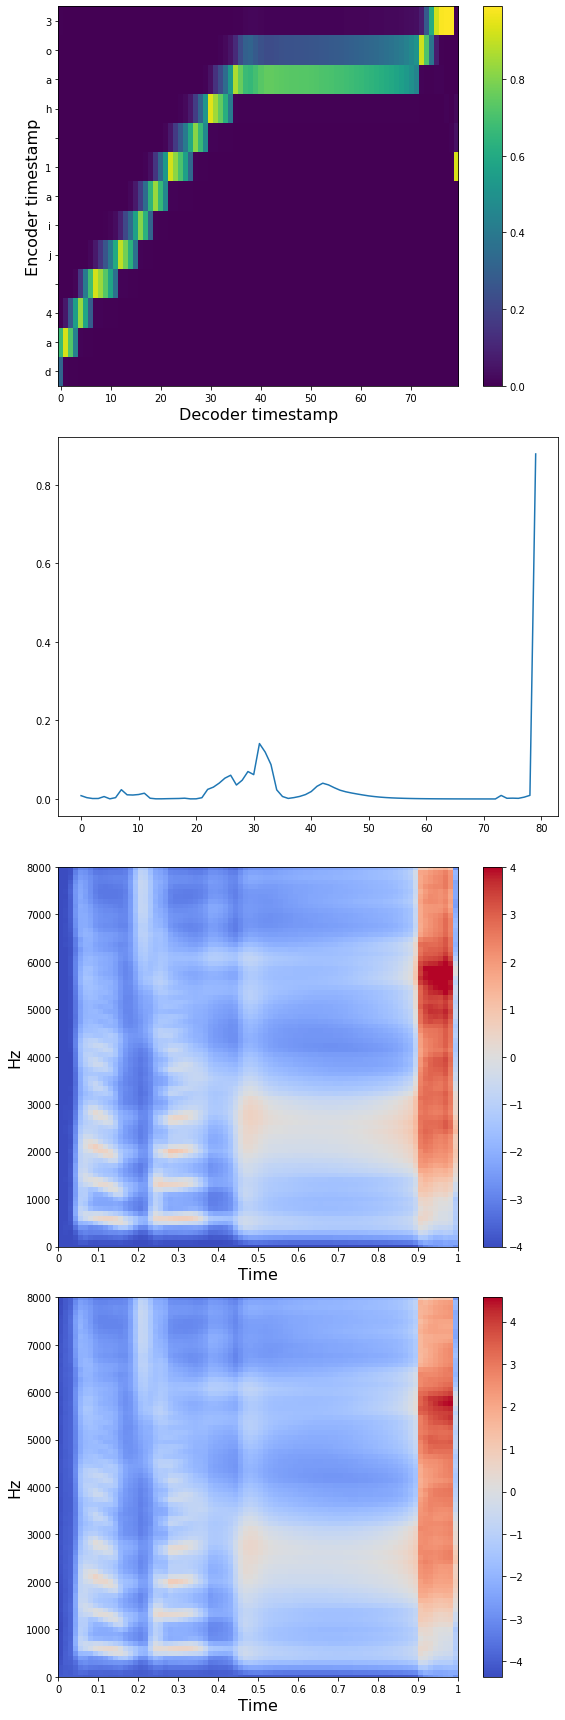

In [197]:
t_1 = time.time()
preprocessed_wav = encoder.preprocess_wav(target_wav, sampling_rate)[:80000]
embed = torch.FloatTensor(encoder.embed_utterance(preprocessed_wav))
embed = embed.unsqueeze(0).cuda()
wave_gl, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis2(model, sentence, CONFIG, use_cuda, ap, embed, False, CONFIG.enable_eos_bos_chars, do_trim_silence=False, create_gl=True)
if CONFIG.model == "Tacotron" and not use_gl:
    # coorect the normalization differences b/w TTS and the Vocoder.
    mel_postnet_spec = ap.out_linear_to_mel(mel_postnet_spec.T).T
mel_postnet_spec = ap._denormalize(mel_postnet_spec)
mel_postnet_spec = ap_vocoder._normalize(mel_postnet_spec)
print(" > Tacotron2-time: {}".format(time.time() - t_1))
if not use_gl:
    waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=20000, overlap=500, ap=ap_vocoder)
    # waveform = wavernn.generate(mel_postnet_spec.T.unsqueeze(0).cuda(), batched=batched_wavernn, target=3000, overlap=100, ap=ap_vocoder)
print("\n >  Run-time: {}".format(time.time() - t_1))
if True:                                                                                                         
    visualize(alignment, mel_postnet_spec, stop_tokens, sentence, ap.hop_length, CONFIG, mel_spec)
if True:
    IPython.display.display(Audio(wave_gl, rate=CONFIG.audio['sample_rate']))
IPython.display.display(Audio(waveform, rate=44100))  
os.makedirs(OUT_FOLDER, exist_ok=True)
file_name = sentence.replace(" ", "_").replace(".","") + ".wav"
out_path = os.path.join(OUT_FOLDER, file_name)
ap.save_wav(waveform, out_path)

In [193]:
IPython.display.display(Audio(waveform, rate=44100)) 

In [185]:
sentence =  "shi2 xian4 ti3 yu4 de5 he2 xin1 jia4 zhi2 guan1"

/search/hadoop02/suanfa/anaconda3/envs/tacotron2/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


torch.Size([1, 512])
 > Tacotron2-time: 10.267239570617676
1065900/1071000 -- batch_size: 51 -- gen_rate: 57.0 kHz -- x_realtime: 1.2  
 >  Run-time: 29.25826859474182


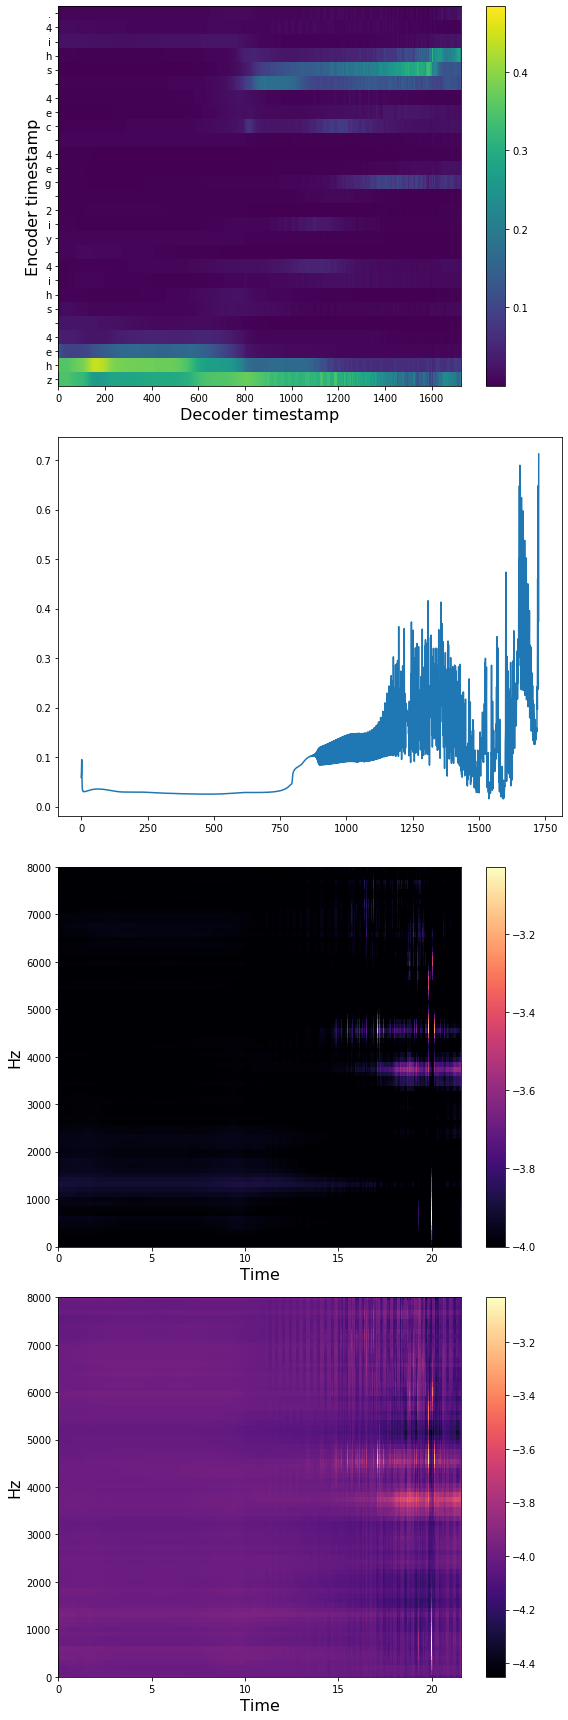

In [108]:
model.eval()
model.decoder.max_decoder_steps = 2000
align, spec, stop_tokens, wav = tts(sentence, target_wav, model, CONFIG, use_cuda, ap, ap_vocoder, use_gl=use_gl, figures=True, target=20000, overlap=500, create_gl=True)